In [1]:
import numpy as np
import pandas as pd


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

# Prediction
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import itertools

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier # Validation
from sklearn import metrics

# Data prepping
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot 
from sklearn import metrics
from sklearn.metrics import classification_report , accuracy_score, confusion_matrix
import scipy.stats
# One of the Ensemle model -- Random Forset which is ensemple of decision trees
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("Libraries imported.")

Libraries imported.


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#from mpl_toolkits import Basemap

In [3]:
datanew = pd.read_csv('gtd/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')
print("Data loaded.")

C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data loaded.


## Exploratory Data Analysis

### Number Of Terrorist Activities Each Year

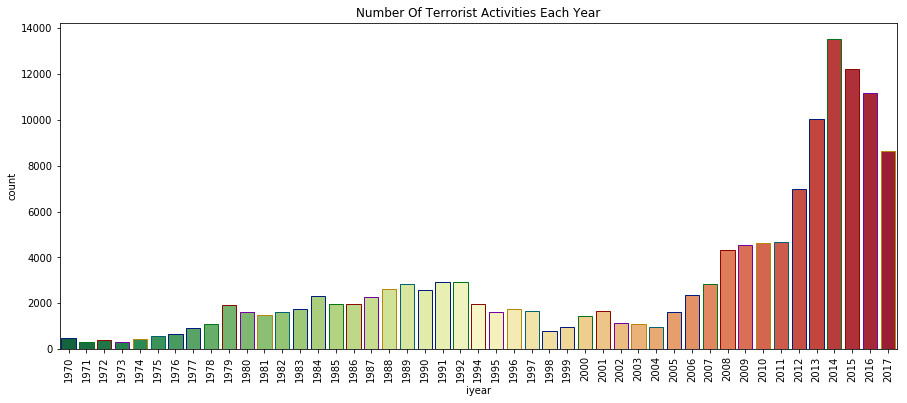

In [88]:
plt.subplots(figsize=(15,6))
sns.countplot('iyear',data=datanew,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.show()

### Number of Attacks v/s Number of Kills

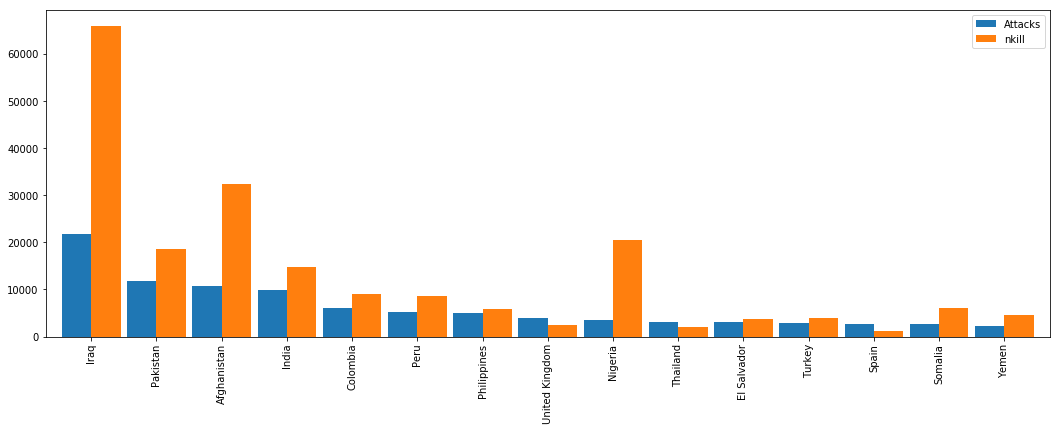

In [89]:
coun_terror=datanew['country_txt'].value_counts()[:15].to_frame()
coun_terror.columns=['Attacks']
coun_kill=datanew.groupby('country_txt')['nkill'].sum().to_frame()
coun_terror.merge(coun_kill,left_index=True,right_index=True,how='left').plot.bar(width=0.9)
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()

### Number of attacks V/s number of injuries

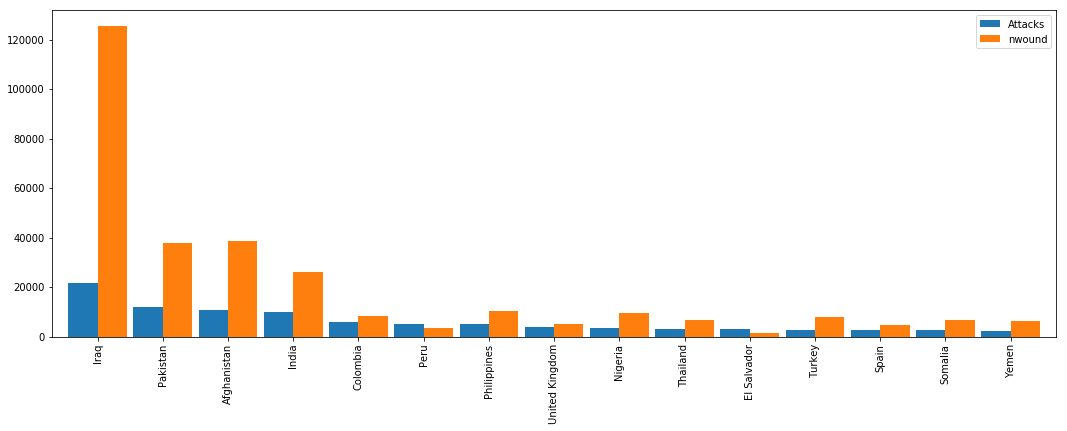

In [90]:
coun_terror=datanew['country_txt'].value_counts()[:15].to_frame()
coun_terror.columns=['Attacks']
coun_kill=datanew.groupby('country_txt')['nwound'].sum().to_frame()
coun_terror.merge(coun_kill,left_index=True,right_index=True,how='left').plot.bar(width=0.9)
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()

### Attacking methods by terrorist

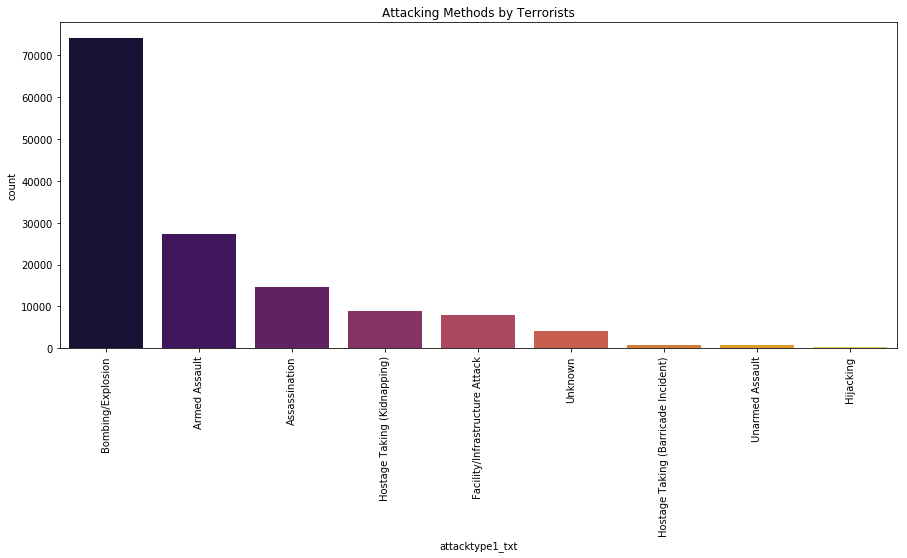

In [91]:
plt.subplots(figsize=(15,6))
sns.countplot('attacktype1_txt',data=datanew,palette='inferno',order=datanew['attacktype1_txt'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Attacking Methods by Terrorists')
plt.show()

### Favourite Targets

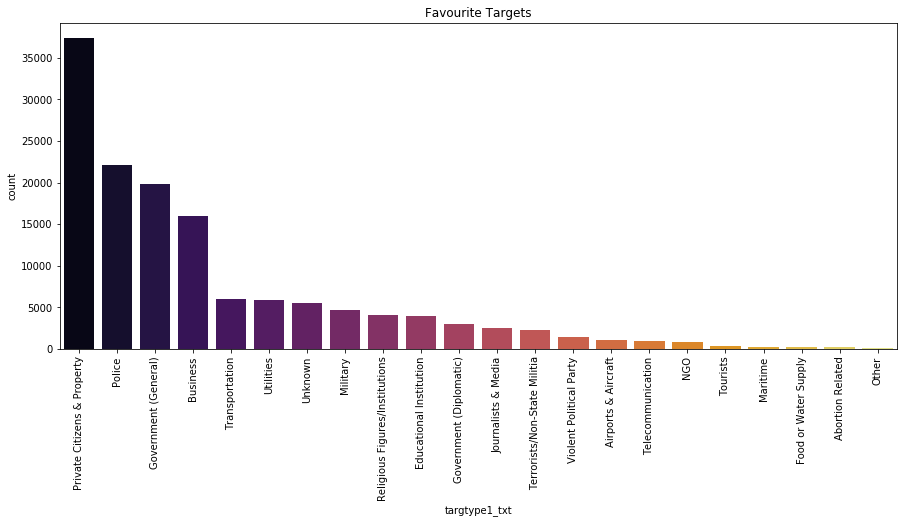

In [92]:
plt.subplots(figsize=(15,6))
sns.countplot('targtype1_txt',data=datanew,palette='inferno',order=datanew['targtype1_txt'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Favourite Targets')
plt.show()

### Types of weapons 

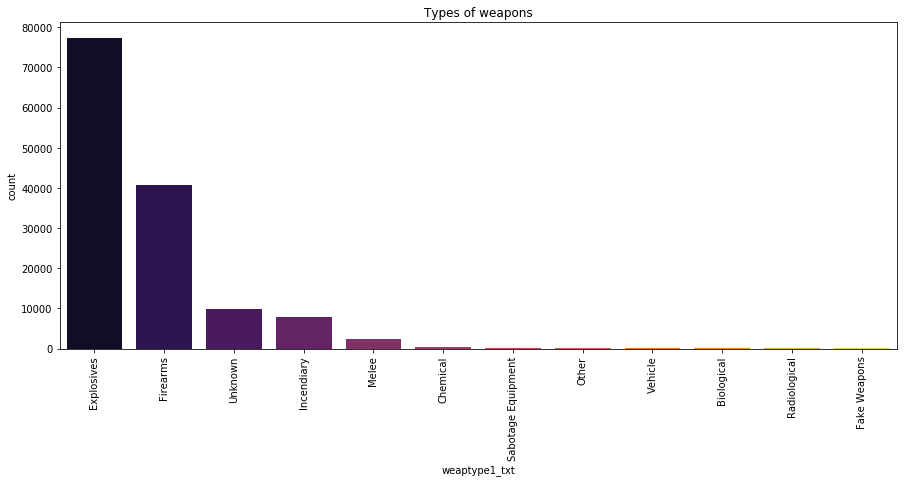

In [93]:
plt.subplots(figsize=(15,6))
sns.countplot('weaptype1_txt',data=datanew,palette='inferno',order=datanew['weaptype1_txt'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Types of weapons')
plt.show()

# Data Preprocessing, Cleaning and Transformation

In [4]:
# Thus, restrict the set the only attacks where the terrorism motive is certain.
datanew = datanew[(datanew.crit1 == 1) & (datanew.crit2 == 1) & (datanew.crit3 == 1) & (datanew.doubtterr == 0)]

# Weapontype column contains very long name for vehicle property -> shorten.
datanew.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

# Replace -9 (unknown) values with 0 (no). -9 values are much more likely to be false than true.
datanew.iloc[:,[6, 15, 16, 17]] = datanew.iloc[:,[6, 15, 16, 17]].replace(-9,0)

# Some values in the claimed category are 2 (should be 0 or 1).
# Assume these were input mistakes and set 2 to 1.
datanew.claimed.replace(2,1, inplace = True)

# Ensure consistent values and make everything lowercase.
datanew.target1 = datanew.target1.str.lower()
datanew.gname = datanew.gname.str.lower()
datanew.summary = datanew.summary.str.lower()    
datanew.target1 = datanew.target1.fillna('unknown').replace('unk','unknown')

# Some nwound and nkill are NaN. Replace them with median.
datanew.nkill = np.round(datanew.nkill.fillna(datanew.nkill.median())).astype(int) 
datanew.nwound = np.round(datanew.nwound.fillna(datanew.nwound.median())).astype(int) 

# Database only reports victims as nkill and nwound. Combine these into ncasualties column.
# Also add has_casualties column.
datanew['ncasualties'] = datanew['nkill'] + datanew['nwound']
datanew['has_casualties'] = datanew['ncasualties'].apply(lambda x: 0 if x == 0 else 1)


def missing_values(datanew,mis_min):
    columns = datanew.columns
    percent_missing = datanew.isnull().sum() * 100 / len(datanew)
    unique = datanew.nunique()
    missing_value_data = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing,
                                 'unique': unique})
    missing_drop = list(missing_value_data[missing_value_data.percent_missing>mis_min].column_name)
    return(missing_drop)


print("Number of features before dropping columns with >50%% of NAN: %.1d" % datanew.shape[1])
datanew['natlty1'].fillna(datanew['country'], inplace = True)

missing_drop = missing_values(datanew,50)
datanew = datanew.drop(missing_drop, axis=1)
datanew = datanew.drop(columns = ['nkillter'])
datanew = datanew.drop(columns = ['crit1'])
datanew = datanew.drop(columns = ['crit2'])
datanew = datanew.drop(columns = ['crit3'])

df1 = pd.DataFrame()
df1 = datanew.doubtterr
datanew = datanew.drop(columns = ['doubtterr'])


print("Number of features after dropping columns with >50%% of NAN: %.1d" % datanew.shape[1])



Number of features before dropping columns with >50% of NAN: 137
Number of features after dropping columns with >50% of NAN: 55


#### Correlation Check to further reduce number of features
We need to further reduce the number of features, so for that we use Correlation, and see how the features are correlated

In [5]:
corr_matrix = datanew.corr()
print(corr_matrix["has_casualties"].sort_values(ascending=False))

has_casualties    1.000000
success           0.237766
region            0.199174
longitude         0.195720
eventid           0.183225
iyear             0.183174
nkill             0.170134
suicide           0.145234
ncasualties       0.100627
latitude          0.077637
nperpcap          0.074236
nwound            0.070933
nwoundte          0.046299
nperps            0.039276
imonth            0.019777
vicinity          0.018979
nwoundus          0.007157
iday              0.007104
individual        0.005803
nkillus           0.005097
guncertain1       0.003814
claimed          -0.007466
specificity      -0.024581
targsubtype1     -0.046798
INT_MISC         -0.047746
country          -0.049983
natlty1          -0.054114
INT_IDEO         -0.063754
INT_LOG          -0.065951
ishostkid        -0.072208
targtype1        -0.086720
INT_ANY          -0.088235
extended         -0.095991
weaptype1        -0.148130
multiple         -0.152829
property         -0.192283
attacktype1      -0.268247
w

#### Correlation Graph

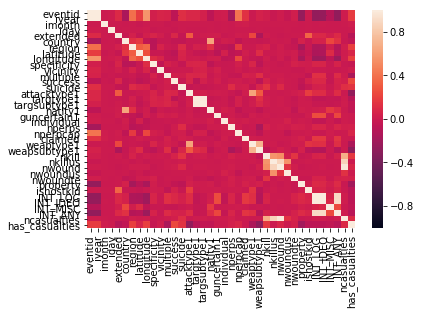

In [6]:
import seaborn as sns
%matplotlib inline



# calculate the correlation matrix
corr = datanew.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin = -1,
        vmax = 1)

In [7]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

# Handling Class Imbalance by Downsampling

In [28]:
print(np.asarray(datanew.has_casualties.value_counts()))

[80885 57994]


In [25]:
import matplotlib.pyplot as plt

df_minority = datanew[datanew.has_casualties==0]
df_majority = datanew[datanew.has_casualties==1]
classes = ['df_minority','df_majority'] 

<BarContainer object of 2 artists>

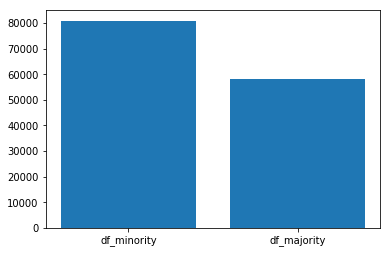

In [32]:
plt.bar(classes, height=np.asarray(datanew.has_casualties.value_counts()))

In [37]:
df_minority = datanew[datanew.has_casualties==0]
df_majority = datanew[datanew.has_casualties==1]
    
from sklearn.utils import resample
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50000,     # to match minority class
                                 random_state=123) # reproducible results

df_minority_downsampled = resample(df_minority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
data = pd.concat([df_majority_downsampled, df_minority_downsampled])
 
# Display new class counts
data.has_casualties.value_counts()

1    50000
0    50000
Name: has_casualties, dtype: int64

<BarContainer object of 2 artists>

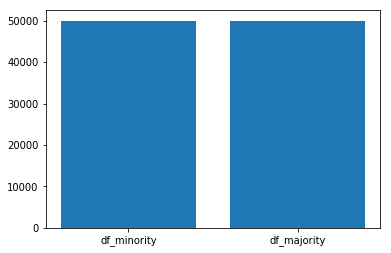

In [41]:
df_minority = datanew[datanew.has_casualties==0]
df_majority = datanew[datanew.has_casualties==1]
classes = ['df_minority','df_majority'] 
plt.bar(classes, height=np.asarray(data.has_casualties.value_counts()))

From correlation matrix and common sense, we were able to remove the redundant features
Final number of features after data preprocessing

In [19]:
feature_cols = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
                'extended',
                'vicinity',
                'doubtterr',
                'multiple',
                'success',
                'suicide',
                'claimed',
                'property',
                'ishostkid',
    
                'country_txt',
                'region',
                'attacktype1_txt',
                'targtype1_txt',
               'weaptype1_txt',
]

# Target is a binary value: were there any casualties in the attack?
target_col = 'has_casualties'


#### Label Encoding the text features 

In [20]:
#Encoding the text features to convert them into classes(categorical)
lb = LabelEncoder()
data['country_txt'] = lb.fit_transform(data['country_txt'])
data['attacktype1_txt'] = lb.fit_transform(data['attacktype1_txt'])
data['targtype1_txt'] = lb.fit_transform(data['targtype1_txt'])
data['weaptype1_txt'] = lb.fit_transform(data['weaptype1_txt'])
data['region_txt'] = lb.fit_transform(data['region_txt'])



In [21]:
# Define X and Y.
X = data[feature_cols].fillna(0)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [69]:
print("x_train =", X_train.shape)
print("y_train =", y_train.shape)
print("x_test =", X_test.shape)
print("y_test =", y_test.shape)
                        

x_train = (70000, 19)
y_train = (70000,)
x_test = (30000, 19)
y_test = (30000,)


#### Checking Feature Importances

In [22]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=20, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

In [23]:
print(importances)

[0.09299098 0.06326674 0.0749213  0.08701968 0.09791733 0.01476117
 0.00762432 0.         0.02199783 0.05925632 0.02428263 0.01348501
 0.06810991 0.00956138 0.0518031  0.03786119 0.11117938 0.1122554
 0.05170635]


Feature ranking:
1. feature 17 (0.112255)
2. feature 16 (0.111179)
3. feature 4 (0.097917)
4. feature 0 (0.092991)
5. feature 3 (0.087020)
6. feature 2 (0.074921)
7. feature 12 (0.068110)
8. feature 1 (0.063267)
9. feature 9 (0.059256)
10. feature 14 (0.051803)
11. feature 18 (0.051706)
12. feature 15 (0.037861)
13. feature 10 (0.024283)
14. feature 8 (0.021998)
15. feature 5 (0.014761)
16. feature 11 (0.013485)
17. feature 13 (0.009561)
18. feature 6 (0.007624)
19. feature 7 (0.000000)


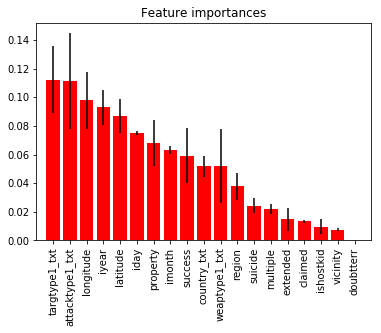

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
fnames = [feature_cols[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), fnames, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Model Construction
## 1. Rule Based Classifier (Baseline Model)

Wall time: 18.6 ms
Wall time: 4.56 ms
Accuracy: 0.4953
Confusion matrix, without normalization
[[    0 15141]
 [    0 14859]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


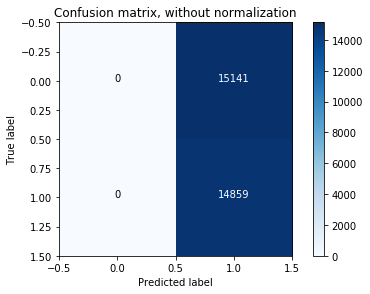

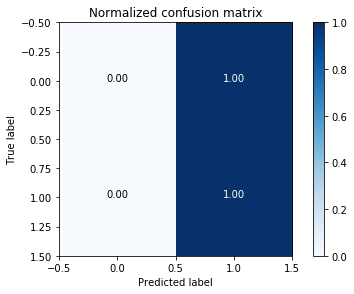

In [46]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
dummy = DummyClassifier(strategy="most_frequent")

%time dummy.fit(X_train, y_train)

%time y_pred_dummy = model.predict(X_test)

#np.mean(y_pred == y_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dummy))

cnf_matrix = confusion_matrix(y_test, y_pred_dummy)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()


#### Recall, Precision, F1 and 10 fold cross validation for Rule Based

In [47]:
print(classification_report(y_test, y_pred_dummy))
# Better validation with K-fold.
#model = RandomForestClassifier(n_estimators=10)

scores_dummy = cross_val_score(dummy, X, y, cv=10) # Ten-fold cross validation.
print(scores_dummy)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_dummy.mean(), scores_dummy.std() * 2))

# calculaye fpr, tpr
fpr_dummy, tpr_dummy, thresholds_dummy = metrics.roc_curve(y_test,  y_pred_dummy)
# calculate Area Under the curve
auc_dummy = metrics.roc_auc_score(y_test, y_pred_dummy)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15141
          1       0.50      1.00      0.66     14859

avg / total       0.25      0.50      0.33     30000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Accuracy: 0.50 (+/- 0.00)


## Linear Based  
   ### 1 (SVM)

Accuracy: 0.6258
Confusion matrix, without normalization
[[14625   516]
 [10710  4149]]
Normalized confusion matrix
[[0.97 0.03]
 [0.72 0.28]]


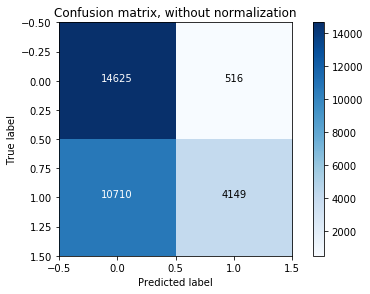

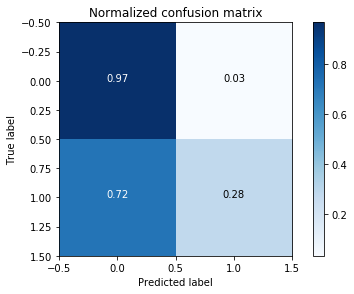

In [48]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train,y_train)
y_pred_svm = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

cnf_matrix = confusion_matrix(y_test, y_pred_svm)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 #Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for SVM

In [49]:
print(classification_report(y_test, y_pred_svm))

# Better validation with K-fold.

scores_svm = cross_val_score(clf, X, y, cv=10) # Ten-fold cross validation.
print(scores_svm)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_svm.mean(), scores_svm.std() * 2))
# calculaye fpr, tpr
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test,  y_pred_svm)
# calculate Area Under the curve
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm)

             precision    recall  f1-score   support

          0       0.58      0.97      0.72     15141
          1       0.89      0.28      0.43     14859

avg / total       0.73      0.63      0.58     30000

[0.57 0.72 0.57 0.52 0.6  0.57 0.52 0.63 0.67 0.67]
Accuracy: 0.60 (+/- 0.13)


### 2 Logistic Regression

Accuracy: 0.7146
Confusion matrix, without normalization
[[10314  4827]
 [ 3735 11124]]
Normalized confusion matrix
[[0.68 0.32]
 [0.25 0.75]]


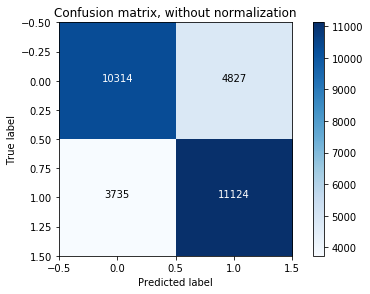

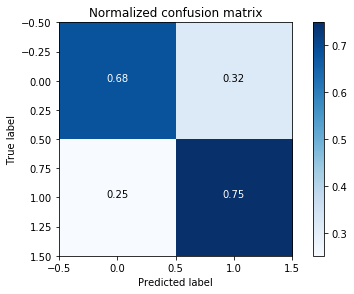

In [50]:
#Import Logistic Regression Classifier model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)


#Predict the response for test dataset
y_pred_lr = lr.predict(X_test)

#np.mean(y_pred_knn == y_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

cnf_matrix = confusion_matrix(y_test, y_pred_lr)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 #Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for Logistic Regression

In [51]:
print(classification_report(y_test, y_pred_lr))

# Better validation with K-fold.

scores_lr = cross_val_score(lr, X, y, cv=10) # Ten-fold cross validation.
print(scores_lr)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_lr.mean(), scores_lr.std() * 2))
# calculaye fpr, tpr
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test,  y_pred_lr)
# calculate Area Under the curve
auc_lr = metrics.roc_auc_score(y_test, y_pred_lr)

             precision    recall  f1-score   support

          0       0.73      0.68      0.71     15141
          1       0.70      0.75      0.72     14859

avg / total       0.72      0.71      0.71     30000

[0.72 0.71 0.72 0.71 0.72 0.71 0.72 0.72 0.72 0.72]
Accuracy: 0.72 (+/- 0.01)


## Tree Based Classifier (Random Forest)

Accuracy: 0.7964666666666667
Confusion matrix, without normalization
[[13610  1531]
 [ 4575 10284]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.31 0.69]]


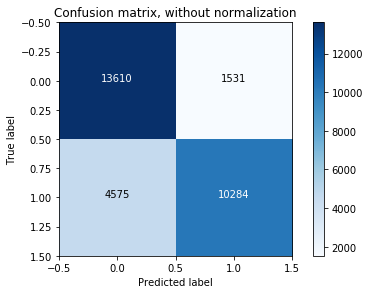

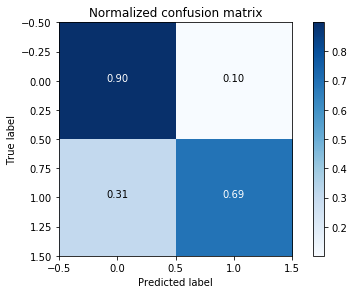

In [52]:
rf = RandomForestClassifier(n_estimators=2)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

cnf_matrix = confusion_matrix(y_test, y_pred_rf)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for Random Forest 

In [53]:
print(classification_report(y_test, y_pred_rf))
# Better validation with K-fold.
#model = RandomForestClassifier(n_estimators=10)

scores_rf = cross_val_score(rf, X, y, cv=10) # Ten-fold cross validation.
print(scores_rf)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_rf.mean(), scores_rf.std() * 2))

# calculaye fpr, tpr
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test,  y_pred_rf)
# calculate Area Under the curve
auc_rf = metrics.roc_auc_score(y_test, y_pred_rf)

             precision    recall  f1-score   support

          0       0.75      0.90      0.82     15141
          1       0.87      0.69      0.77     14859

avg / total       0.81      0.80      0.79     30000

[0.79 0.8  0.8  0.79 0.79 0.8  0.79 0.8  0.8  0.8 ]
Accuracy: 0.80 (+/- 0.01)


## Probabilistic Based (Naive Bayes)

Accuracy: 0.7154333333333334
Confusion matrix, without normalization
[[12450  2691]
 [ 5846  9013]]
Normalized confusion matrix
[[0.82 0.18]
 [0.39 0.61]]


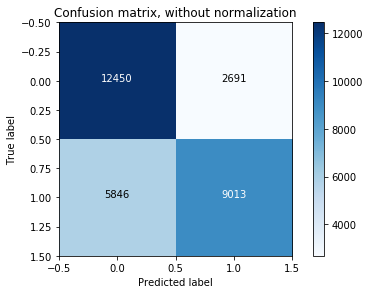

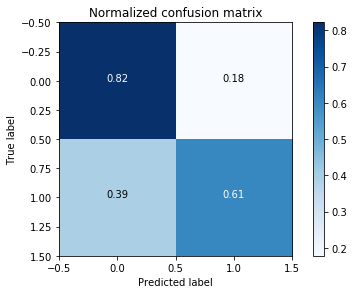

In [54]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_naive = gnb.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_naive))

cnf_matrix = confusion_matrix(y_test, y_pred_naive)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for Naive Bayes

In [55]:
print(classification_report(y_test, y_pred_naive))
# Better validation with K-fold.
scores_naive = cross_val_score(gnb, X, y, cv=10) # Ten-fold cross validation.
print(scores_naive)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_naive.mean(), scores_naive.std() * 2))

# calculaye fpr, tpr
fpr_naive, tpr_naive, thresholds_naive = metrics.roc_curve(y_test,  y_pred_naive)
# calculate Area Under the curve
auc_naive = metrics.roc_auc_score(y_test, y_pred_naive)

             precision    recall  f1-score   support

          0       0.68      0.82      0.74     15141
          1       0.77      0.61      0.68     14859

avg / total       0.72      0.72      0.71     30000

[0.71 0.71 0.71 0.71 0.72 0.71 0.71 0.72 0.71 0.72]
Accuracy: 0.71 (+/- 0.01)


## Distance Based (KNN)

Accuracy: 0.7584
Confusion matrix, without normalization
[[11439  3702]
 [ 3546 11313]]
Normalized confusion matrix
[[0.76 0.24]
 [0.24 0.76]]


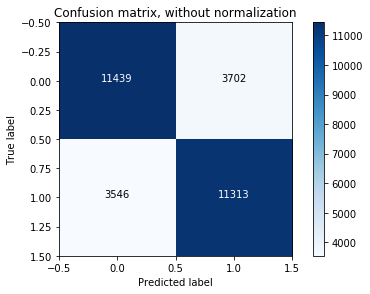

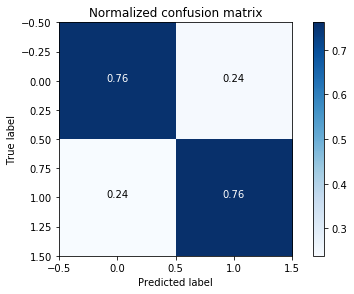

In [56]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_knn = knn.predict(X_test)

np.mean(y_pred_knn == y_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))

cnf_matrix = confusion_matrix(y_test, y_pred_knn)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 #Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for KNN

In [57]:
print(classification_report(y_test, y_pred_knn))

# Better validation with K-fold.

scores_knn = cross_val_score(knn, X, y, cv=10) # Ten-fold cross validation.
print(scores_knn)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_knn.mean(), scores_knn.std() * 2))

# calculaye fpr, tpr
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test,  y_pred_knn)
# calculate Area Under the curve
auc_knn = metrics.roc_auc_score(y_test, y_pred_knn)

             precision    recall  f1-score   support

          0       0.76      0.76      0.76     15141
          1       0.75      0.76      0.76     14859

avg / total       0.76      0.76      0.76     30000

[0.76 0.77 0.77 0.77 0.76 0.76 0.77 0.76 0.77 0.76]
Accuracy: 0.77 (+/- 0.01)


## Ensemble (Adaboost)

Accuracy: 0.8107666666666666
Confusion matrix, without normalization
[[12459  2682]
 [ 2995 11864]]
Normalized confusion matrix
[[0.82 0.18]
 [0.2  0.8 ]]


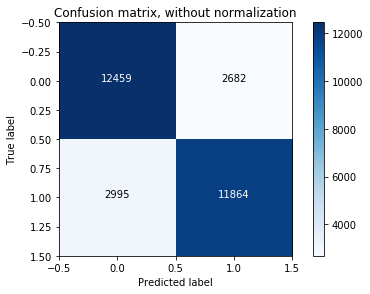

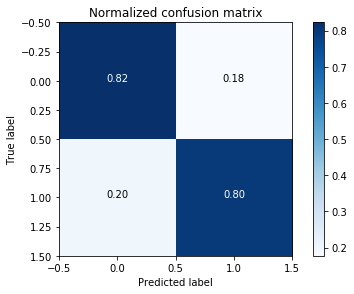

In [58]:
adaboost = AdaBoostClassifier( DecisionTreeClassifier() , n_estimators= 10 , learning_rate= 1 )
adaboost.fit(X_train, y_train)

y_pred_ada = adaboost.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_ada))

cnf_matrix = confusion_matrix(y_test, y_pred_ada)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 #Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Recall, Precision, F1 and 10 fold cross validation for Adaboost

In [59]:
print(classification_report(y_test, y_pred_ada))

# Better validation with K-fold.

scores_ada = cross_val_score(adaboost, X, y, cv=10) # Ten-fold cross validation.
print(scores_ada)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores_ada.mean(), scores_ada.std() * 2))
# calculaye fpr, tpr
fpr_ada, tpr_ada, thresholds_ada = metrics.roc_curve(y_test,  y_pred_ada)
# calculate Area Under the curve
auc_ada = metrics.roc_auc_score(y_test, y_pred_ada)

             precision    recall  f1-score   support

          0       0.81      0.82      0.81     15141
          1       0.82      0.80      0.81     14859

avg / total       0.81      0.81      0.81     30000

[0.82 0.82 0.82 0.82 0.81 0.81 0.82 0.81 0.82 0.82]
Accuracy: 0.82 (+/- 0.01)


## AUC Of the models

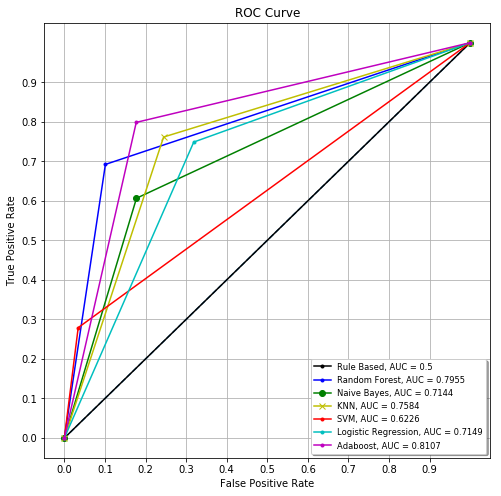

In [60]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(8,8))

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))


pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model

# Dummy Classifier Rule Based 
ax.plot(fpr_dummy, tpr_dummy, marker='.', color = 'k',  label='Rule Based, AUC = '+str(round(auc_dummy,4)))
# Random Forest
ax.plot(fpr_rf, tpr_rf, marker='.', color = 'b',  label='Random Forest, AUC = '+str(round(auc_rf,4)))
# Naive Bayes
ax.plot(fpr_naive, tpr_naive, marker='o', color = 'g',  label='Naive Bayes, AUC = '+str(round(auc_naive,4)))
# KNN
ax.plot(fpr_knn, tpr_knn, marker='x', color = 'y',  label='KNN, AUC = '+str(round(auc_knn,4)))
# SVM Classifier
ax.plot(fpr_svm, tpr_svm, marker='.',  color = 'r',  label='SVM, AUC = '+str(round(auc_svm,4)))
# Logistic Regression Classifier
ax.plot(fpr_lr, tpr_lr, marker='.',  color = 'c',  label='Logistic Regression, AUC = '+str(round(auc_lr,4)))
# Adaboost
ax.plot(fpr_ada, tpr_ada, marker='.',  color = 'm',  label='Adaboost, AUC = '+str(round(auc_ada,4)))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')



plt.title('ROC Curve')
plt.grid(True)

legend = ax.legend(loc='lower right', shadow=True, fontsize='small')

Adaboost has the highest AUC followed by Random forest and KNN

## Statistical T-Test

In [72]:
#For our t-test we'll be using top 3 models. Random Forest, KNN, and AdaBoost

CrossValidationScores = pd.DataFrame()
CrossValidationScores['Random Forest'] = scores_rf
CrossValidationScores['KNN'] = scores_knn
CrossValidationScores['AdaBoost'] = scores_ada

In [74]:
CrossValidationScores

,Random Forest,KNN,AdaBoost
0,0.7920,0.7597,0.8205
1,0.7962,0.7659,0.8151
2,0.7972,0.7680,0.8194
3,0.7927,0.7661,0.8169
4,0.7923,0.7624,0.8115
5,0.7983,0.7640,0.8100
6,0.7947,0.7662,0.8157
7,0.7993,0.7645,0.8130
8,0.7966,0.7734,0.8162
9,0.7986,0.7628,0.8203


In [76]:
rf = CrossValidationScores['Random Forest']
knn = CrossValidationScores['KNN']
ada = CrossValidationScores['AdaBoost']

In [87]:
alpha = 0.05
# if p > alpha - > then there's no significance difference between two models
# if p < alpha -> then there is  significance difference between two models

print("For Random Forest & Ada Boost")
t,p = scipy.stats.ttest_ind(rf,ada)
print("t = ",t, "p = ",p)
if p > alpha:
    print("Then there's no significance difference between two models")
else:
    print("Then there is significance difference between two models")
    print('\n')


print("For Random Forest & KNN")
t,p = scipy.stats.ttest_ind(rf,knn)
print("t = ",t, "p = ",p)
if p > alpha:
    print("There's no significance difference between two models")
else:
    print("There is significance difference between two models")
    print('\n')

print("For KNN & Ada Boost")
t,p = scipy.stats.ttest_ind(knn,ada)
print("t = ",t, "p = ",p)
if p > alpha:
    print("There's no significance difference between two models")
else:
    print("There is significance difference between two models")
    print('\n')



     

For Random Forest & Ada Boost
t =  -14.047488415490578 p =  3.843671057000156e-11
Then there is significance difference between two models


For Random Forest & KNN
t =  21.002959835339805 p =  4.131972818608158e-14
There is significance difference between two models


For KNN & Ada Boost
t =  -30.95097723748795 p =  4.6180919256293585e-17
There is significance difference between two models




From t-test, we came to know that there is a significant difference between these models. So, we chose AdaBoost as our best model for the given problem domain